## Figure 5 - Supervised predictions

Deep learning MOA and gene pathway predictions.

Note that panel a is a lucid chart diagram of the deep learning workflow.
Here, I compile panels B, C, and D.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure5_deeplearning")
extensions <- c(".png", ".pdf")

In [3]:
# Set internal constants
dl_moa_targets <- c(
    "mek inhibitor" = "MEK inhibitor",
    "mtor inhibitor" = "MTOR inhibitor",
    "egfr inhibitor" = "EGFR inhibitor",
    "hsp inhibitor" = "HSP inhibitor",
    "plk inhibitor" = "PLK inhibitor",
    "glucocorticoid receptor antagonist" = "Glucocorticoid receptor antagonist"
)

metric_dir <- file.path("..", "2.MOA-prediction", "metrics")
performance_dir <- file.path("../2.MOA-prediction/4.model_viz/performance_results")

In [4]:
# Load average precision scores for all models and targets
ap_file <- file.path(metric_dir, "average_precision_full_results.tsv.gz")

ap_cols <- readr::cols(
  average_precision = readr::col_double(),
  target = readr::col_character(),
  assay = readr::col_character(),
  model = readr::col_character(),
  shuffle = readr::col_logical(),
  data_split = readr::col_character(),
  target_category = readr::col_character()
)

ap_df <- readr::read_tsv(ap_file, col_types = ap_cols)

print(dim(ap_df))
head(ap_df, 2)

[1] 48547     9


average_precision,target,assay,model,shuffle,data_split,subsample_status,target_category,n_pos_count
<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<dbl>
0.0009466525,11-beta hydroxysteroid dehydrogenase inhibitor,cp,mlknn,TRUE,train,TRUE,moa,17
0.0009980768,11-beta-hsd1 inhibitor,cp,mlknn,TRUE,train,TRUE,moa,18


In [5]:
# Load data for visualization
targets_list <- list(
    "panel_a" = c("mek inhibitor", "mtor inhibitor", "egfr inhibitor"),
    "panel_b" = c("hsp inhibitor", "plk inhibitor", "glucocorticoid receptor antagonist")
)

results_dir <- file.path("..", "2.MOA-prediction", "metrics", "pr_curves")
results_prefix <- "precision_recall_curve__"
results_suffix <- ".tsv.gz"
plot_category <- "main"

pr_df <- list()
for (panel in names(targets_list)) {
    pr_df[[panel]] <- list()
    focus_targets <- targets_list[[panel]]
    for (target in focus_targets) {
        
        # Load precision recall curves
        pr_temp_df <- process_pr_deeplearning_data(
            target = target,
            results_dir = results_dir,
            results_prefix = results_prefix,
            results_suffix = results_suffix,
            plot_category = plot_category
        )
        
        # Reorder model factor
        pr_temp_df$model <- factor(pr_temp_df$model, levels = names(model_names))
        
        # Recode and reorder compound names
        pr_temp_df$target <- factor(pr_temp_df$target, levels = focus_targets)
        pr_temp_df$target <- dplyr::recode_factor(pr_temp_df$target, !!!dl_moa_targets)
        
        # Store in list
        pr_df[[panel]][[target]] <- pr_temp_df
    }
    pr_df[[panel]] <- dplyr::bind_rows(pr_df[[panel]])
}

## Panel B

Compounds that work in both assays similarily

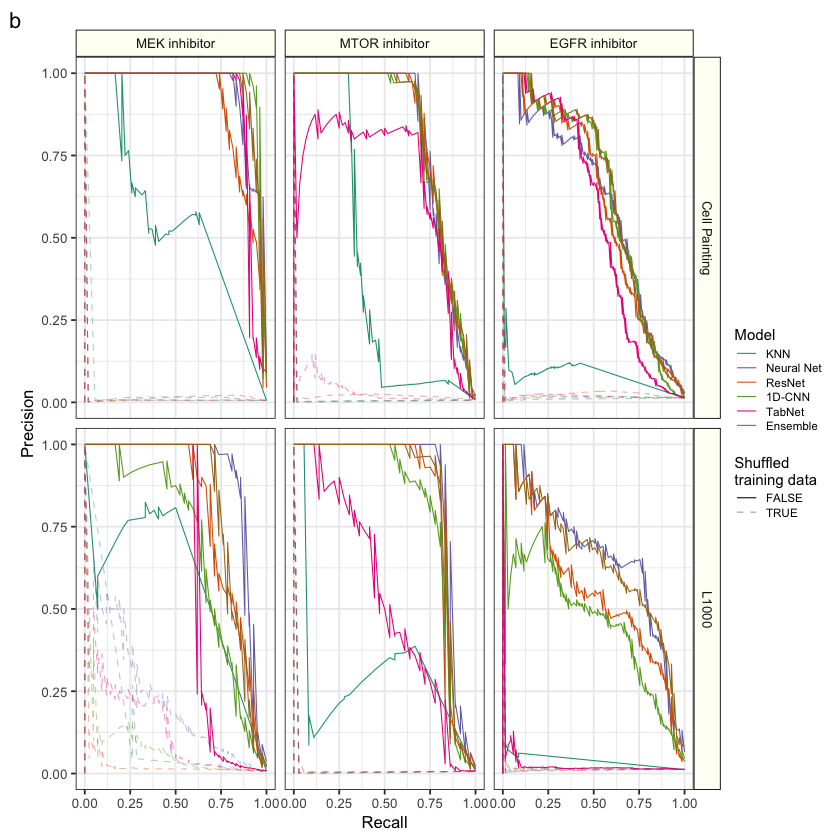

In [6]:
panel_b_gg <- (
    ggplot(pr_df[["panel_a"]], aes(x = recall_round, y = precision_round))
    + geom_line(aes(color = model, linetype = data_shuffle, alpha = data_shuffle), lwd = 0.3)
    + facet_grid("assay~target")
    + figure_theme
    + xlab("Recall")
    + ylab("Precision")
    + scale_color_manual(name = "Model", labels = model_names, values = model_colors)
    + scale_linetype_manual(name = "Shuffled\ntraining data", labels = shuffled_labels, values = shuffled_linetypes)
    + scale_alpha_manual(name = "Shuffled\ntraining data", labels = shuffled_labels, values = shuffled_alphas)
    + guides(
        color = guide_legend(order = 1),
        linetype = guide_legend(order = 2),
        alpha = guide_legend(order = 2)
    )
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.1, "cm"),
        legend.key.size = unit(0.6, "lines"),
        legend.key.width = unit(1, "lines")
    )
    + labs(tag = "b")
)

panel_b_gg

## Panel C - Scatter plot comparing L1000 and Cell Painting predictions

In [7]:
ap_moa_compliment_df <- ap_df %>%
    dplyr::group_by(assay, target) %>%
    dplyr::filter(
        target_category == "moa",
        data_split == "test",
        !shuffle
    ) %>%
    dplyr::top_n(n = 1, wt = average_precision) %>%
    tidyr::drop_na() %>%
    reshape2::dcast(
        target ~ assay,
        value.var = "average_precision"
    )

print(dim(ap_moa_compliment_df))
head(ap_moa_compliment_df, 3)

[1] 245   3


,target,cp,L1000
,<chr>,<dbl>,<dbl>
1,5 alpha reductase inhibitor,0.007459586,0.003220568
2,abl kinase inhibitor,0.099749461,0.009101489
3,acat inhibitor,0.012745009,0.069589038


In [8]:
# Test the correlation between the two assays
cor.test(ap_moa_compliment_df$cp, ap_moa_compliment_df$L1000, method = "spearman")

Warning message in cor.test.default(ap_moa_compliment_df$cp, ap_moa_compliment_df$L1000, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  ap_moa_compliment_df$cp and ap_moa_compliment_df$L1000
S = 740110, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6980344 


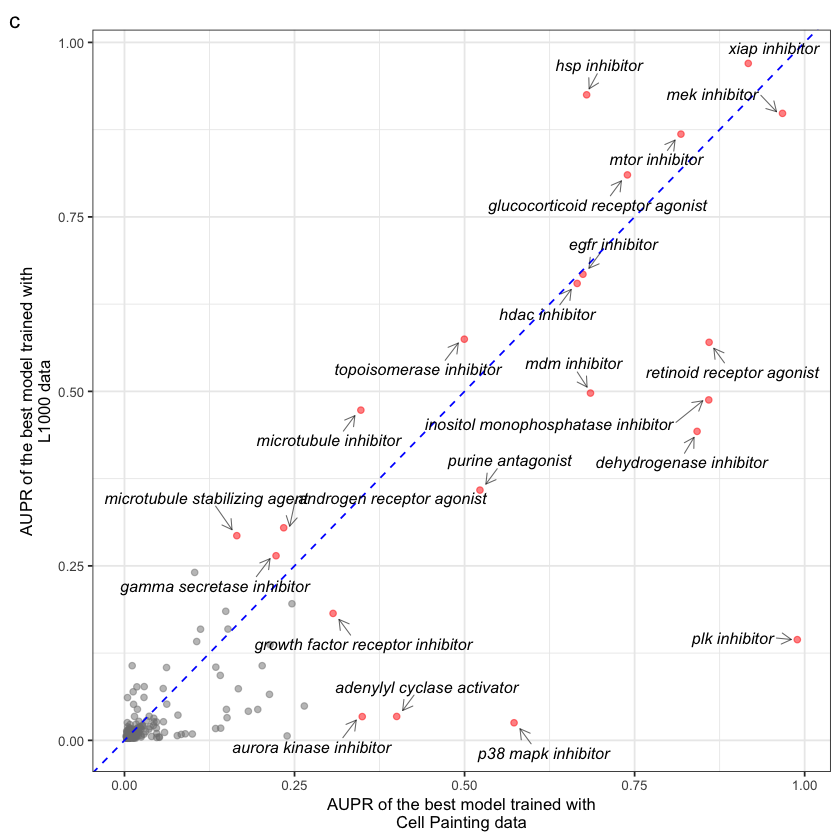

In [9]:
color_logic <- ap_moa_compliment_df$cp > 0.3 | ap_moa_compliment_df$L1000 > 0.25

# Plot average precision scores
panel_c_gg <- (
    ggplot(ap_moa_compliment_df, aes(y = L1000, x = cp))
    + geom_point(color = ifelse(color_logic, "red", "grey50"), alpha = 0.5)
    + figure_theme
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "blue")
    + xlab("AUPR of the best model trained with\nCell Painting data")
    + ylab("AUPR of the best model trained with\nL1000 data")
    + geom_text_repel(
        data = subset(ap_moa_compliment_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.3,
        segment.alpha = 0.6,
        size = 3.4,
        force = 3,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.5,
        aes(
            x = cp,
            y = L1000,
            label = target,
        )
    )
    + labs(tag = "c")
)

panel_c_gg

## Panel D - General performance summary reveals overall poor performance

In [10]:
# Load metrics results
metrics_file <- file.path(performance_dir, "all_performance_metrics.csv")

metrics_cols <- readr::cols(
    id_name = readr::col_character(),
    metrics = readr::col_character(),
    values = readr::col_double(),
    profile_tech = readr::col_character(),
    model = readr::col_character(),
    shuffle = readr::col_logical()
)

all_metrics_df <- readr::read_csv(metrics_file, col_types = metrics_cols) %>%
    dplyr::mutate(updated_metric = values / 100)

# Process data
all_metrics_df$profile_tech <- dplyr::recode(
    all_metrics_df$profile_tech,
    `Cell painting` = "Cell Painting",
    `Cell painting subsample` = "Cell Painting (subsample)"
)
all_metrics_df$metrics <- dplyr::recode(
    all_metrics_df$metrics, `Precision-Recall_AUC` = "Precision-recall", `ROC_AUC` = "ROC"
)
all_metrics_df$metrics <- factor(all_metrics_df$metrics, levels = c("ROC", "Precision-recall"))
all_metrics_df$model <- factor(
    all_metrics_df$model,
    levels = c("Ml-KNN", "Simple NN", "ResNet", "1D-CNN", "TabNet", "Models Ensemble")
)
all_metrics_df$model <- dplyr::recode(
    all_metrics_df$model, `Models Ensemble` = "Ensemble", "Ml-KNN" = "KNN", "Simple NN" = "Neural Net" 
)

head(all_metrics_df)

id_name,metrics,values,profile_tech,model,shuffle,updated_metric
<chr>,<fct>,<dbl>,<chr>,<fct>,<lgl>,<dbl>
CP_mlknn,Precision-recall,1.013924,Cell Painting,KNN,FALSE,0.01013924
CP_resnet,Precision-recall,3.776332,Cell Painting,ResNet,FALSE,0.03776332
CP_cnn,Precision-recall,4.524989,Cell Painting,1D-CNN,FALSE,0.04524989
CP_tabnet,Precision-recall,3.130228,Cell Painting,TabNet,FALSE,0.03130228
CP_simplenn,Precision-recall,4.201865,Cell Painting,Neural Net,FALSE,0.04201865
CP_blend,Precision-recall,4.144751,Cell Painting,Ensemble,FALSE,0.04144751


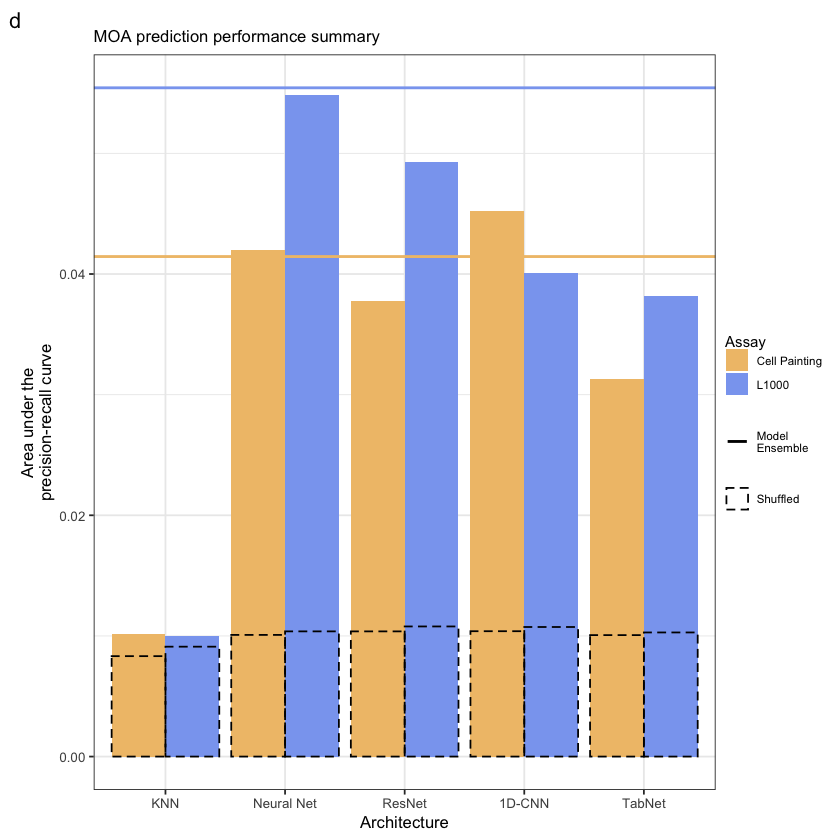

In [11]:
panel_d_df <- all_metrics_df %>%
    dplyr::filter(profile_tech %in% c("Cell Painting", "L1000")) %>%
    dplyr::filter(metrics == 'Precision-recall')

ensemble_df <- panel_d_df %>%
    dplyr::filter(model == "Ensemble")

panel_d_df <- panel_d_df %>%
    dplyr::filter(model != "Ensemble")

panel_d_gg <- (
    ggplot(data = NULL, aes(x = model, y = updated_metric))
    + geom_bar(
        data = panel_d_df %>% dplyr::filter(!shuffle),
        stat = "identity",
        aes(fill = profile_tech),
        position = "dodge"
    )
    + geom_bar(
        data = panel_d_df %>% dplyr::filter(shuffle),
        stat = "identity",
        aes(color = profile_tech),
        alpha = 0,
        position = "dodge",
        linetype = "dashed"
    )
    + ggtitle("MOA prediction performance summary")
    + figure_theme
    + theme(
        legend.spacing.y = unit(0.01, "cm"),
        legend.box.spacing = unit(0.01, "cm"),
        legend.key.size = unit(0, "lines"),
        legend.key.width = unit(1, "lines"),
        legend.key.height = unit(1, "lines"),
        plot.title = element_text(size = 10)
    )
    + scale_fill_manual("Assay", values = assay_colors)
    + scale_color_manual(
        breaks = "Cell Painting",
        name = "",
        values = c("black", "black"),
        labels = c("Shuffled")
    )
    + scale_linetype_manual(name = "", values = "solid", labels = "Model\nEnsemble")
    + geom_hline(
        data = ensemble_df,
        aes(yintercept = updated_metric, linetype = "Ensemble"),
        color = paste(assay_colors),
        lwd = 0.8
    )    
    + xlab("Architecture")
    + ylab("Area under the\nprecision-recall curve")
    + guides(
        fill = guide_legend(order = 1),
        color = guide_legend(order = 3),
        linetype = guide_legend(order = 2)
    )
    + labs(tag = "d")
)

panel_d_gg

## Compile the lower half of Figure 5

Only the data panels

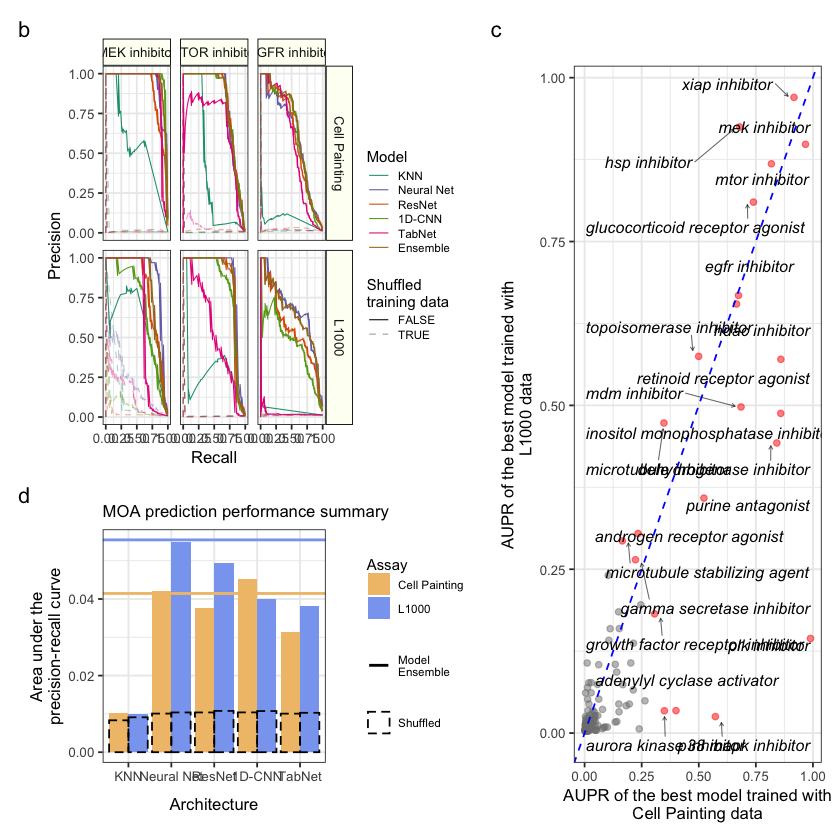

In [12]:
fig_5_gg <- (
    (
        panel_b_gg /
        panel_d_gg
    ) + plot_layout(heights = c(1, 0.65)) | panel_c_gg
) + plot_layout(widths = c(0.9, 1))

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, fig_5_gg, height = 6, width = 13, dpi = 500)
}

fig_5_gg